In [4]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
from matplotlib.pyplot import cm 

data = pd.read_csv("carsdata_features.csv", engine='c')

In [3]:
data.columns.values

array(['NO_ABS', 'NO_accoudoir_central', 'NO_airbag_conducteur',
       'NO_airbag_lateraux', 'NO_airbag_passager', 'NO_airbag_tete_rideau',
       'alesage_mm', 'course_piston_mm', 'NO_allumage_auto_feux',
       'NO_antipatinage', 'NO_appuis_tete_arriere',
       'NO_assistant_freinage', 'NO_banquette_arriere_rabattable',
       'NO_blocage_differentiel', 'NO_bluetooth', 'capacite_charge_max_kg',
       'capacite_moteur_cc', 'NO_capteur_stationnement',
       'NO_capteur_temp_liquide_refroidissement', 'LPG_carburant',
       'bio_ethanol_carburant', 'diesel_carburant',
       'natural_gas_carburant', 'catalyseur_onregular',
       'catalyseur_part_filter', 'catalyseur_egular', 'No_clim_bizone',
       'NO_climatisation', 'NO_commande_audio_volant', 'compteur_jours',
       'conso_extra_urbaine_l_par_100km', 'conso_extra_urbaine_km_par_l',
       'conso_mixte_l_par_100km', 'conso_mixte_km_par_l',
       'conso_urbaine_l_par_100km', 'conso_urbaine_km_par_l', 'couple_max',
       'coupl

Les différents types de carrrosseries:

- **`bus`**, 
- **`cabriolet`**, 
- **`coupe`**, 
- **`hatchback`**, 
- **`mpv`**, 
- **`pickup`**, 
- **`sedan`**, 
- **`stationwagon`**, 
- **`suv_crossover`**


## Est-ce que le prix de vente d'une voiture neuve est différent en fonction du type de carrosserie?


In [49]:
df = pd.DataFrame()
df["bus"] = data.prix.where(data.bus == 1)/1000
df["cabriolet"] = data.prix.where(data.cabriolet == 1)/1000
df["coupe"] = data.prix.where(data.coupe == 1)/1000
df["hatchback"] = data.prix.where(data.hatchback == 1)/1000
df["mpv"] = data.prix.where(data.mpv == 1)/1000
df["pickup"] = data.prix.where(data.pickup == 1)/1000
df["sedan"] = data.prix.where(data.sedan == 1)/1000
df["stationwagon"] = data.prix.where(data.stationwagon == 1)/1000
df["suv_crossover"] = data.prix.where(data.suv_crossover == 1)/1000


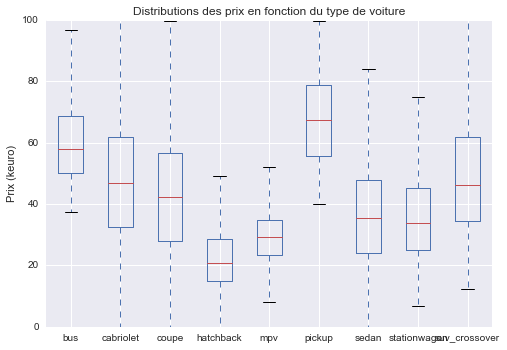

In [53]:
df.plot.box()
plt.ylim(0,100)
plt.ylabel("Prix (keuro)")
plt.title("Distributions des prix en fonction du type de voiture")
plt.show()

Les espaces (mvp) et voitures à hayon (hatchback), c'est à dire les petites voitures 3 ou 5 portes, sont parmis les moins chères. Les plus chères sont les pickups.

# Quels facteurs influencent le plus le prix de vente ?

## Feature selection

In [134]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
lr = LinearRegression(n_jobs=-1)
selector = RFECV(lr, step=1, cv=10)

In [135]:
filtered_data = data[data.prix.notnull() ]
len(filtered_data)

63652

In [136]:
y = np.array(filtered_data.prix)
X = np.array(filtered_data.drop(["prix",'marque', 'modele', 'version'],axis=1))
X.shape

(63652L, 186L)

In [137]:
import numpy as np
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X)
X = imp.transform(X)

In [138]:
selector = selector.fit(X,y)

In [125]:
selector.n_features_

165

In [145]:
df = filtered_data.drop(["prix",'marque', 'modele', 'version'],axis=1)
selected_features = df.iloc[:,selector.support_].columns.values

In [146]:
len(selected_features)

165

In [151]:
v = [not i for i in selector.support_]
non_selected_features = df.iloc[:,v].columns.values

In [152]:
len(non_selected_features)

21

In [153]:
non_selected_features

array(['conso_mixte_l_par_100km', 'couple_max_tr_min',
       'intervale_km_entretien', 'freins_arriere_diametre_disc',
       'freins_avant_diametre_disc', 'garantie_generale_km', 'hauteur_mm',
       'largeur_mm', 'longueur_mm', 'longueur_coffre_min',
       'longueur_coffre_max', 'masse_max_frein_avec_remorque',
       'masse_max_frein_sans_remorque', 'masse_vide', 'max_boule_presse',
       'max_charge_toit', 'NO_ordinateur_bord', 'puissance_max_tr_min',
       'tr_min_120_kmh', 'volume_coffre_min', 'volume_coffre_max'], dtype=object)

## Model selection by CV

In [167]:
y = np.array(filtered_data.prix)
X = np.array(filtered_data[selected_features])
imp.fit(X)
X = imp.transform(X)

In [256]:
import time
t1 = time.time()
model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], normalize=False,cv=20, n_jobs=-1, eps=5e-3).fit(X,y)
t_enet = time.time() - t1

In [257]:
t_enet

21.24500012397766

In [258]:
model.l1_ratio_

1.0

In [259]:
model.alpha_

58744.405117219409

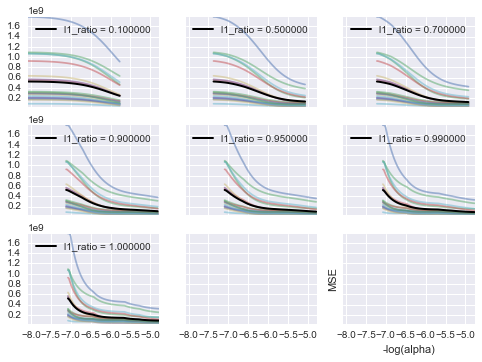

In [260]:
f, axarr = plt.subplots(3,3, sharey=True, sharex=True)

for i in range(len(model.alphas_)):
    col = i % 3
    row = int(i/3)
    
    lr = model.l1_ratio[i]
    m_log_alphas = - np.log10(model.alphas_[i,:])
    mse_path_ = model.mse_path_[i,:,:]
    axarr[row,col].plot(m_log_alphas, mse_path_, alpha=0.5)
    axarr[row,col].plot(m_log_alphas, mse_path_.mean(axis=-1),'k',label='l1_ratio = %f' % lr, linewidth=2)
    #axarr[row,col].axvline(-np.log10(model.alpha_), linestyle='--', color='k', label='alpha CV')
    axarr[row,col].legend()
plt.ylabel('MSE')
plt.xlabel('-log(alpha)')
plt.axis('tight')
plt.show()

Le MSE mminimum est obtenu pour un ratio L1 égale à 1. La penalité appliquée est donc L1 (Lasso).

In [261]:
model.coef_

array([  -0.        ,    0.        ,   -0.        ,   -0.        ,
         -0.        ,   -0.        ,   -0.        ,   -0.        ,
         -0.        ,   -0.        ,    0.        ,   -0.        ,
          0.        ,   -0.        ,   -0.        ,  -11.3981334 ,
          9.26056673,   -0.        ,    0.        ,    0.        ,
          0.        ,   -0.        ,    0.        ,   -0.        ,
         -0.        ,    0.        ,   -0.        ,   -0.        ,
         -0.        ,   -0.        ,    0.        ,    0.        ,
          0.        ,   -0.        ,    0.        ,   43.81845302,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,   -0.        ,    0.        ,
         -0.        ,    0.        ,   -0.        ,    0.        ,
          0.78290544,    0.        ,    0.        ,    0.        ,
         -0.        ,   -0.        ,    0.        ,    0.        ,
          0.        ,   -0.        ,   -0.        ,    0.     